<a href="https://colab.research.google.com/github/yangyang1598/Deeplearning/blob/main/%EA%B3%BC%EC%A0%9C2_TF_hub_transfer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 텐서플로 허브와 전이학습

* https://www.tensorflow.org/tutorials/images/transfer_learning_with_hub?hl=ko
* 위 주소에 들어가서 전이학습을 연습합니다.
* Run in Google Colab 을 이용하여 진행합니다.
* 과제는 전반적인 코드리뷰 입니다.

In [ ]:
import matplotlib.pylab as plt

import tensorflow as tf

In [ ]:
!pip install -q -U tf-hub-nightly
import tensorflow_hub as hub

from tensorflow.keras import layers

     |████████████████████████████████| 109 kB 31.0 MB/s 


In [ ]:
classifier_url ="https://tfhub.dev/google/tf2-preview/mobilenet_v2/classification/2"

In [ ]:
IMAGE_SHAPE = (224, 224)

classifier = tf.keras.Sequential([
    hub.KerasLayer(classifier_url, input_shape=IMAGE_SHAPE+(3,))
])

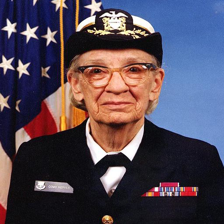

In [ ]:
import numpy as np
import PIL.Image as Image

grace_hopper = tf.keras.utils.get_file('image.jpg','https://storage.googleapis.com/download.tensorflow.org/example_images/grace_hopper.jpg') #keras에 있는 이미지를 그레이스관련 이미지를 들고 옴
grace_hopper = Image.open(grace_hopper).resize(IMAGE_SHAPE)#사이즈 조정
grace_hopper

In [ ]:
#데이터 전처리 
grace_hopper = np.array(grace_hopper)/255.0

grace_hopper.shape

(224, 224, 3)

In [ ]:
result = classifier.predict(grace_hopper[np.newaxis, ...])#각 클래스의 확률 계산
result.shape

(1, 1001)

In [ ]:
predicted_class = np.argmax(result[0], axis=-1) 
predicted_class

653

In [ ]:
labels_path = tf.keras.utils.get_file('ImageNetLabels.txt','https://storage.googleapis.com/download.tensorflow.org/data/ImageNetLabels.txt')#라벨 내용 txt 파일 경로 복사
imagenet_labels = np.array(open(labels_path).read().splitlines()) #txt 속 내용 배열로 변환하기(사용 가능하도록)

24576/10484 [======================================================================] - 0s 0us/step


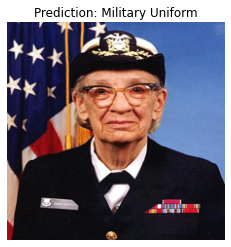

In [ ]:
plt.imshow(grace_hopper)
plt.axis('off')
predicted_class_name = imagenet_labels[predicted_class]#라벨 배열에 예측 모델을 넣어 예측 정보에 대한 정보 prediceted_class_name에 넣기
_ = plt.title("Prediction: " + predicted_class_name.title())

In [ ]:
data_root = tf.keras.utils.get_file(
  'flower_photos','https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz',
   untar=True) #관련 데이터 로딩

228827136/228813984 [==============================] - 2s 0us/step


In [ ]:
image_generator = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1/255)#Tensor의 이미지 모듈은 0~1사이의 상수입력을 기대함
image_data = image_generator.flow_from_directory(str(data_root), target_size=IMAGE_SHAPE)#image_batch와 label_batch를 return

Found 3670 images belonging to 5 classes.


In [ ]:
for image_batch, label_batch in image_data: #위의 return값을 각각 print하여 shape확인(제대로 만들어졌는가)
  print("Image batch shape: ", image_batch.shape)
  print("Label batch shape: ", label_batch.shape)
  break

Image batch shape:  (32, 224, 224, 3)
Label batch shape:  (32, 5)


In [ ]:
result_batch = classifier.predict(image_batch)#각 클래스의 확률 계산
result_batch.shape

(32, 1001)

In [ ]:
predicted_class_names = imagenet_labels[np.argmax(result_batch, axis=-1)]#예측된 라벨 정보들 출력
predicted_class_names

array(['picket fence', 'hip', 'vase', 'daisy', 'daisy',
       'sulphur butterfly', 'daisy', 'obelisk', 'safety pin', 'titi',
       'porcupine', 'rapeseed', 'daisy', 'daisy', 'bell pepper', 'vase',
       'sea urchin', 'bonnet', 'sulphur butterfly', 'pinwheel',
       'cabbage butterfly', 'vase', 'bubble', 'daisy', 'sea anemone',
       'daisy', 'daisy', 'lipstick', 'earthstar', 'vase', 'quill',
       'daisy'], dtype='<U30')

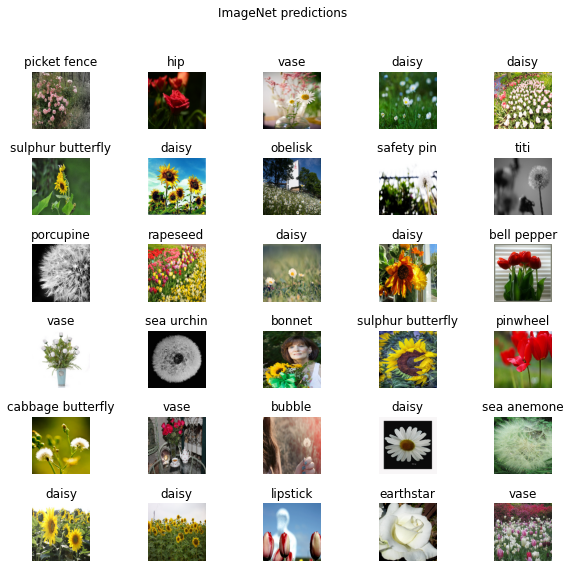

In [ ]:
plt.figure(figsize=(10,9))
plt.subplots_adjust(hspace=0.5)
for n in range(30):#예측된 이미지와 라벨을 for문을 통해 출력
  plt.subplot(6,5,n+1)
  plt.imshow(image_batch[n])
  plt.title(predicted_class_names[n])
  plt.axis('off')
_ = plt.suptitle("ImageNet predictions")

In [ ]:
feature_extractor_url = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/2"

In [ ]:
feature_extractor_layer = hub.KerasLayer(feature_extractor_url,
                                         input_shape=(224,224,3))# feature 추출기 생성

In [ ]:
feature_batch = feature_extractor_layer(image_batch)#img 길이가 1280인 벡터 반환
print(feature_batch.shape)

(32, 1280)


In [ ]:
feature_extractor_layer.trainable = False

In [ ]:
model = tf.keras.Sequential([
  feature_extractor_layer,
  layers.Dense(image_data.num_classes, activation='softmax')#새 분류계층 추가
])

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer_1 (KerasLayer)   (None, 1280)              2257984   
_________________________________________________________________
dense (Dense)                (None, 5)                 6405      
Total params: 2,264,389
Trainable params: 6,405
Non-trainable params: 2,257,984
_________________________________________________________________


In [ ]:
predictions = model(image_batch)
predictions.shape

TensorShape([32, 5])

In [ ]:
model.compile(
  optimizer=tf.keras.optimizers.Adam(),
  loss='categorical_crossentropy',
  metrics=['acc']) #모델 학습

In [ ]:
class CollectBatchStats(tf.keras.callbacks.Callback):
  def __init__(self):
    self.batch_losses = []
    self.batch_acc = []

  def on_train_batch_end(self, batch, logs=None):
    self.batch_losses.append(logs['loss'])
    self.batch_acc.append(logs['acc'])
    self.model.reset_metrics()

In [ ]:
steps_per_epoch = np.ceil(image_data.samples/image_data.batch_size)

batch_stats_callback = CollectBatchStats()

history = model.fit_generator(image_data, epochs=2,
                              steps_per_epoch=steps_per_epoch,
                              callbacks = [batch_stats_callback])

/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/2
115/115 [==============================] - 96s 807ms/step - loss: 0.2617 - acc: 0.9688
Epoch 2/2
115/115 [==============================] - 93s 811ms/step - loss: 0.3598 - acc: 0.8750


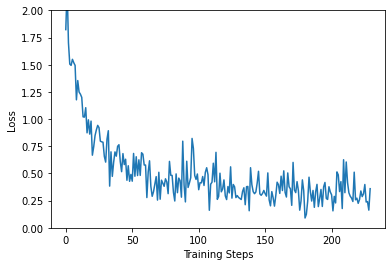

In [ ]:
plt.figure() #손실 시각화
plt.ylabel("Loss")
plt.xlabel("Training Steps")
plt.ylim([0,2])
plt.plot(batch_stats_callback.batch_losses)

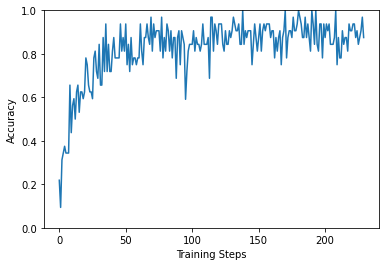

In [ ]:
plt.figure()#정확도 시각화
plt.ylabel("Accuracy")
plt.xlabel("Training Steps")
plt.ylim([0,1])
plt.plot(batch_stats_callback.batch_acc)

In [ ]:
class_names = sorted(image_data.class_indices.items(), key=lambda pair:pair[1])
class_names = np.array([key.title() for key, value in class_names])
class_names

array(['Daisy', 'Dandelion', 'Roses', 'Sunflowers', 'Tulips'],
      dtype='<U10')

In [ ]:
predicted_batch = model.predict(image_batch)
predicted_id = np.argmax(predicted_batch, axis=-1)
predicted_label_batch = class_names[predicted_id]


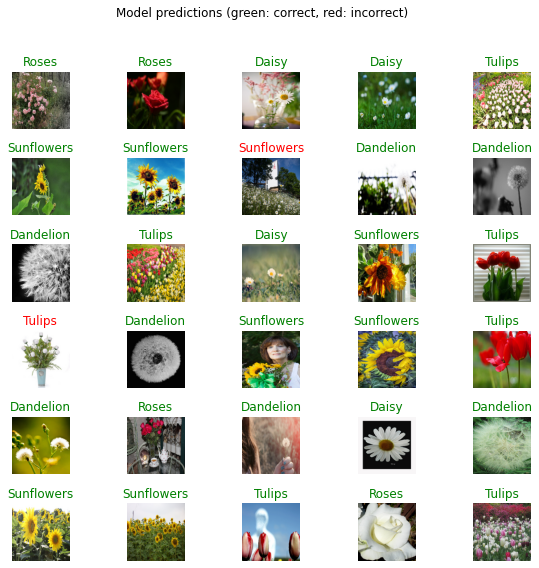

In [ ]:
label_id = np.argmax(label_batch, axis=-1)#학습한 결과를 이용한 결과 재출력(꽃에 대한 결과만 출력)
plt.figure(figsize=(10,9))
plt.subplots_adjust(hspace=0.5)
for n in range(30):
  plt.subplot(6,5,n+1)
  plt.imshow(image_batch[n])
  color = "green" if predicted_id[n] == label_id[n] else "red"
  plt.title(predicted_label_batch[n].title(), color=color)
  plt.axis('off')
_ = plt.suptitle("Model predictions (green: correct, red: incorrect)")

In [ ]:
import time
t = time.time()

export_path = "/tmp/saved_models/{}".format(int(t))#저장 모델 내보내기
model.save(export_path, save_format='tf')

export_path#내보낸 경로

INFO:tensorflow:Assets written to: /tmp/saved_models/1635396826/assets


INFO:tensorflow:Assets written to: /tmp/saved_models/1635396826/assets


'/tmp/saved_models/1635396826'

In [ ]:
reloaded = tf.keras.models.load_model(export_path)#내보낸 파일 다시 불러오기
result_batch = model.predict(image_batch)
reloaded_result_batch = reloaded.predict(image_batch)
abs(reloaded_result_batch - result_batch).max()#정상적으로 내보내졌는지 체크

0.0